In [94]:
include("../src/project.jl")
theme(:wong2)
using ProgressMeter

In [2]:
### load a description of the HK1 locus, including its coordinates on the genome, sequence, and a table of the motifs
hk1desc = load_seq_motif()

(chrom = "chr10", loc = 71108610:71108717, seq = "CATTTCCCGCAGGCAGAGTTTTTGCTTGCCCTGTATTCCAGCACAGGCTGGTACTCGAGACACATCTGTCCTGTGTTTGTTTTCCATTATTTGCTGGTAATAATGGCT", motifs = 3×8 DataFrame
 Row │ chrom    start     stop      name     seq        valid  rstart  rstop 
     │ String7  Int64     Int64     String7  String15   Bool   Int64   Int64 
─────┼───────────────────────────────────────────────────────────────────────
   1 │ chr10    71108643  71108649  NFAT     TATTCCA    false      34     40
   2 │ chr10    71108660  71108668  NKX2     GTACTCGAG  false      51     59
   3 │ chr10    71108683  71108689  FOX      TGTTTGT    false      74     80)

# Include functions defined in `hk1_inference` notebook

todo: these should be shift into the repo

In [3]:
"""
    bindingconfig(desc, config)
    
    Adds a binding configuration to a problem description, if the problem contains n motifs, then the total number of bound states is 2^n.

    `config` is a vector of pairs (s_i, p_i) where s_i is the state number and p_i is its probability

    e.g for 3 motifs:
    StateNumber    State
        0        [0, 0, 0]       # no TFs bound
        1        [1, 0, 0]       # Only a TF bound at binding motif 1
        2        [0, 1, 0]        .
        3        [1, 1, 0]        .
        4        [0, 0, 1]        .
        5        [1, 0, 1]       # 1 and 3 bound
        6        [0, 1, 1]        .
        7        [1, 1, 1]       # all bound

"""
function bindingconfig(desc, config)
   
    m = 2^size(desc.motifs, 1) - 1### max config
    states = first.(config)
    @assert all(s -> 0 <= s <= m, states)
    probs = last.(config)
    @assert all(p -> 0 <= p <= m, probs)
    
    (; desc..., states, probs)
end

bindingconfig

In [4]:
"""
    bindingconfig(desc, config)
    
    Adds a binding configuration to a problem description, if the problem contains n motifs, then the total number of bound states is 2^n.

    `config` is a vector of pairs (s_i, p_i) where s_i is the state number and p_i is its probability

    e.g for 3 motifs:
    StateNumber    State
        0        [0, 0, 0]       # no TFs bound
        1        [1, 0, 0]       # Only a TF bound at binding motif 1
        2        [0, 1, 0]        .
        3        [1, 1, 0]        .
        4        [0, 0, 1]        .
        5        [1, 0, 1]       # 1 and 3 bound
        6        [0, 1, 1]        .
        7        [1, 1, 1]       # all bound

"""
function bindingconfig(desc, config)
   
    m = 2^size(desc.motifs, 1) - 1### max config
    states = first.(config)
    @assert all(s -> 0 <= s <= m, states)
    probs = last.(config)
    @assert all(p -> 0 <= p <= m, probs)
    
    (; desc..., states, probs)
end

bindingconfig

In [6]:
"""
    sample_smf_data(tf_footprints, seq, nreads=10, open_meth_prob=0.9, closed_meth_prob=0.05, fwprob=0.5)

    Sample methylation data from a sequence with a given number of reads, and a given probability of methylation for open and closed sites.

"""
function sample_smf_AT(desc; nreads=10, open_meth_prob=0.9, closed_meth_prob=0.05, frprob=0.5)

    fi_A = findall('A', desc.seq)
    fi_T = findall('T', desc.seq)
    
    ### build dictionary of states indexes to bound tfs
    ### e.g Dict(0 => [], 1 => [1], 2 => [2], 3 => [1, 2], ..., 7 => [1, 2, 3])
    state_dict = Dict(k => Set(findall(digits(k, base=2, pad=size(desc.motifs, 1)) .== 1)) for k = 0:(2^size(desc.motifs, 1) - 1))
    ### determine which of the footprints are in use in this sample
    bound_tfs = sort!(unique(mapreduce(s -> collect(state_dict[s]), vcat, desc.states)))
    

    ### which of the As/Ts are within a motif
    a_in_motif = [index_in_motif(i, desc.motifs.rstart[bound_tfs], desc.motifs.rstop[bound_tfs], bound_tfs) for i in fi_A]
    t_in_motif = [index_in_motif(i, desc.motifs.rstart[bound_tfs], desc.motifs.rstop[bound_tfs], bound_tfs) for i in fi_T]

    ### sample the strands and the states for each read 
    sample_strands = rand(Bernoulli(frprob), nreads)
    sample_states  = desc.states[rand(Categorical(desc.probs), nreads)]
    
    ### reads are stored as bitarray of methylated bases true for meth, false for no meth
    sample_reads = BitArray{1}[]
    
    for (strand, state) in zip(sample_strands, sample_states)
        state_desc = state_dict[state] ### state of this read
        base_in_motif = strand ? a_in_motif : t_in_motif ### strand of this read
        sample_read = rand.(Bernoulli.(ifelse.(base_in_motif .∈ Ref(state_desc), closed_meth_prob, open_meth_prob))) ## sample the occcupied footprint
        push!(sample_reads, sample_read) 
    end
    
    
    (;fi_A, fi_T, a_in_motif, t_in_motif, sample_strands, sample_states, sample_reads, bound_tfs, desc)
    
end

### helper function to return which motif a given base pair index is in.
function index_in_motif(i, starts, stops, bound_tfs)
    for (k, (s, e)) in enumerate(zip(starts, stops))
        (s <= i <= e) && return bound_tfs[k]
    end
    return 0
end


## plot where TF motifs are given a description
function plotdescription(desc; y=1, lw=10, kwargs...)
    p = plot()
    
    for (k, (s, e)) in enumerate(zip(desc.motifs.rstart, desc.motifs.rstop))
       plot!([s, e], [y, y], lab="TF Motif $k", c=k, lw=lw; kwargs...) 
    end
    p
end

## plot simulated SMF reads grouping by state (labelled group here) or strand
function plotreads!(sample; offset = 0, group=nothing, sort=nothing)
    
    if isnothing(sort)
        si = 1:length(sample.sample_reads)
    elseif sort == :strand
        si = sortperm(sample.sample_strands)
    elseif sort == :state
        si = sortperm(sample.sample_states)
    end
        
    labels = Set{String}()
        
    for (k, i) = enumerate(si)
        
        ind = sample.sample_strands[i] ? sample.fi_A : sample.fi_T
        if isnothing(group)
            c = :black
            l = "SMF Reads"
        elseif group == :strand
            c = sample.sample_strands[i] + 1
            l = ifelse(sample.sample_strands[i], "+ | A", "- | T")
        elseif group == :state
            c = sample.sample_states[i]
            l = string("S", c)
        end
        if l ∈ labels
            ll = ""
        else
            ll = l
            push!(labels, l)
        end
        scatter!(ind[sample.sample_reads[i]], fill(k + offset, sum(sample.sample_reads[i])), marker=(:vline, 5), c=c, lab="",)
        plot!([ind[1], ind[end]], [k+offset, k+offset], c=c, lab=ll)
    end
    plot!(ylabel="Reads")
end

## function to layout multiple plots for a sample
function plot_AT_samples(sample; group=nothing, sort=group)
    
    # top plot
    pr = plot(leg=:outertopright, xaxis=false, bottom_margin=-4mm)
    plotreads!(sample, group=group, sort=sort)
    
    # middle plot
    pm = plot(mean_meth(sample)..., ylabel="Proportion", lab="Mean Meth.", leg=:outertopright, marker=:circle, bottom_margin=0mm, top_margin=-3mm, fill=0, fillalpha=0.1, xaxis=false)
    plot!(leg=:outertopright, xticks=false)

    # bottom plot
    pd = plotdescription(sample.desc)
    scatter!(sample.fi_A, 3.0.*ones(size(sample.fi_A)), marker=:square, lab="A")
    scatter!(sample.fi_T, 5.0.*ones(size(sample.fi_A)), marker=:square, lab="T")
    plot!(leg=:outertopright, top_margin=-2mm, ylims=(-1, 6), yaxis=false)

    plot(pr, pm, pd, layout=grid(3, 1, heights=[0.8, 0.1, 0.1]), link=:x, grid=false, size=(1000, 700), fontfamily="helvetica", left_margin=5mm)

end


### function to aggregate the methylation per base pair
function total_meth(sample)
    meth_f = zeros(Int, length(sample.fi_A))
    meth_r = zeros(Int, length(sample.fi_T))

    tA = 0
    tT = 0
    for i = 1:length(sample.sample_reads)
        
        if sample.sample_strands[i]
            meth_f .+= sample.sample_reads[i]
            tA +=1
        else
            meth_r .+= sample.sample_reads[i]
            tT += 1
        end
        
    end
    
    meth = [meth_f ; meth_r]
    total = [fill(tA, length(meth_f)) ; fill(tT, length(meth_r))]
    mc = [sample.fi_A ; sample.fi_T]
    
    si = sortperm(mc)

    mc[si], total[si], meth[si]
end

function mean_meth(sample)
    pos, total, meth = total_meth(sample)
    pos, meth./total
end


mean_meth (generic function with 1 method)

# Setup configs

In [7]:
config_tf1 = [(1, 1.0)] # sample state 1 = 100 with prob 1
config_tf2 = [(2, 1.0)] # sample state 2 = 010 with prob 1
config_tf3 = [(4, 1.0)] # sample state 4 = 001 with prob 1
config_all = [(7, 1.0)] # sample state 7 = 111 with prob 1
config_tf1_tf2_tf3 = [(1, 1/3), (2, 1/3), (4, 1/3)] ### sample states 1, 2, 3 each with prob 1/3
config_5 = [(5, 1.0)] # sample state 7 = 111 with prob 1
## two biologically more representative configurations
config_56  = [(0, 0.1), (5, 0.4), (6, 0.5)] # sample state 0 = 000 (no binding) prob 0.1, state 5 = 101 with prob 0.4, and state 6 = 011, with prob 0.5
config_57  = [(0, 0.1), (5, 0.4), (7, 0.5)] # sample state 0 = 000 (no binding) prob 0.1, state 5 = 101 with prob 0.4, and state 7 = 111, with prob 0.5
### parameters
nreads = 150
open_meth_prob = 0.8 ## probability of methylation if base pair is not bound (accessible)
closed_meth_prob = 0.1 ## probabilty of methylation if base pair is bound  (not accesible)
frprob = 0.5; ## probabilty of sampling forward or reverse strand

In [9]:
### the mean meth rate combines information on forward and reverse strands where the A's are in different positions


function smf_sample_stats(smf_sample)
    
    ### the mean meth rate combines information on forward and reverse strands where the A's are in different positions
    positions, total, totalmeth = total_meth(smf_sample) ## calculate mean meth rate
    methrate = totalmeth./total
    
    ### calculate some useful variables marking the footprints
    ### the positions variable above tells us where the methylated positions are but has thrown away which is an A and which is a T
    ### recalculate some of this information for helper
    mc = [smf_sample.fi_A ; smf_sample.fi_T]  ### mc gives the methylated positions of As followed by that of Ts
    si = sortperm(mc)
    ## Note: mc[si] == positions variable above, this is the genomic positions where we get information
    
    ## which of these positions are As or Ts
    atind = [fill(1, size(smf_sample.fi_A)) ; fill(2, size(smf_sample.fi_T))][si] ### note reordering by si
    
    
    

    ### useful locations of footprints
    footprints = [smf_sample.a_in_motif ; smf_sample.t_in_motif][si]
    footprintids = filter(!iszero, unique(footprints))
    footprint_locations = [extrema(findall(footprints .== i)) for i in footprintids]
    
    (; footprints, footprintids, footprint_locations, atind, positions, total, totalmeth, methrate, smf_sample)
    
end

smf_sample_stats (generic function with 1 method)

In [12]:
smf_sample_stats_tf1 = smf_sample_stats(sample_smf_AT(bindingconfig(hk1desc, config_tf1), nreads=150, open_meth_prob=open_meth_prob, closed_meth_prob=closed_meth_prob, frprob=frprob));
smf_sample_stats_57 = smf_sample_stats(sample_smf_AT(bindingconfig(hk1desc, config_57), nreads=150, open_meth_prob=open_meth_prob, closed_meth_prob=closed_meth_prob, frprob=frprob));
smf_sample_stats_all = smf_sample_stats(sample_smf_AT(bindingconfig(hk1desc, config_all), nreads=150, open_meth_prob=open_meth_prob, closed_meth_prob=closed_meth_prob, frprob=frprob));

# Inference models

In a change to inference models used in [hk1_inference.ipynb](hk1_inference.ipynb) all models here work in real sequence space, not the index space of As and Ts.

In [127]:
[smf_sample_stats_tf1.positions smf_sample_stats_tf1.totalmeth smf_sample_stats_tf1.total]

58×3 Matrix{Int64}:
   2  60  74
   3  57  76
   4  55  76
   5  61  76
  11  60  74
  15  54  74
  17  55  74
  19  69  76
  20  63  76
  21  65  76
  22  62  76
  23  63  76
  26  57  76
   ⋮      
  90  63  76
  91  57  76
  92  65  76
  95  63  76
  98  60  76
  99  62  74
 100  62  74
 101  58  76
 102  65  74
 103  54  74
 104  62  76
 108  62  76

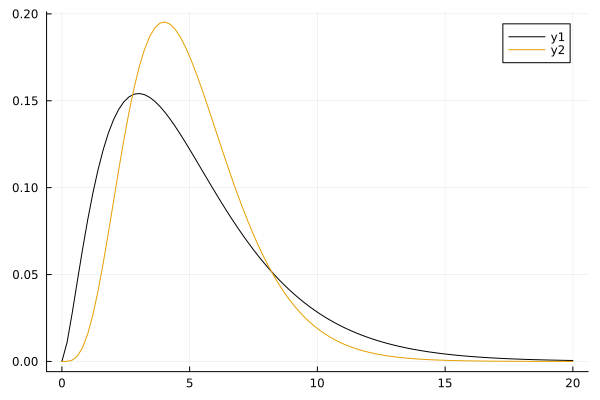

In [134]:
xp = range(0, 20, length=100)
plot(xp, pdf.(Gamma(2.5, 2), xp))
plot!(xp, pdf.(Gamma(5, 1), xp))

In [11]:

fp_model2A_cond_pos(sample) = fp_single_cond_pos(sample.positions, sample.totalmeth, sample.total)
@model function fp_single_cond_pos(positions, totalmeth, total, min_footprint=0, min_interval=0)
    
    start              ~ Uniform(1, positions[end]) ### where the footprint start
    footprint_length   ~ Gamma(2.5, 2) ### the footprint length ideally don't want to hard code the prior
    
    
    ### different meth priors for background (open regions) and footprints 
    ### open/background has higher prob of being methylated than footprints
    meth_bg ~ Beta(5, 2) ## methylation of background
    meth_fp ~ Beta(2, 5) ## methylation rate at each footprint and the background
    

    ## Loop over the footprints sampling the total methylated bases at each position depending on whether base is in the footprint
    for i = 1:length(positions)
        mp = (start < positions[i] < (start + footprint_length)) ? meth_fp : meth_bg
        totalmeth[i] ~ Binomial(total[i], mp)
    end
end



fp_single_cond_pos (generic function with 6 methods)

In [141]:
sampler = HMC(0.01, 5)
@time fp_chain_2A_cp = sample(fp_model2A_cond_pos(smf_sample_stats_tf1), sampler, 10_000); #only execute if sample has a single footpring

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.000803 seconds (7.08 M allocations: 533.526 MiB, 4.94% gc time)


In [142]:
function plot_model2A(chain, sample)
    p_meth = plot(ylims=(0, 1))
    plot!(chain["meth_bg"], lab="bg", title="Meth prob")
    plot!(chain["meth_fp"], lab="fp")
    hline!([open_meth_prob], c=1, ls=:dash, lab="true open prob")
    hline!([closed_meth_prob], c=2, ls=:dash, lab="true closed prob")
    
    
    p_start = plot(chain["start"], lab="start", ylims=(0, length(smf_sample_stats_tf1.footprints)))
    plot!(chain["footprint_length"] .+ chain["start"], lab="stop")

    hline!(sample.positions[first.(sample.footprint_locations)], ls=:dash, c=1, lab="true start")
    hline!(sample.positions[last.(sample.footprint_locations)], ls=:dash, c=2, lab="true stop")
    plot(p_meth, p_start,layout=(1,2), size=(1000, 300), leg=:outertopright, fmt=:png)
end

plot_model2A (generic function with 2 methods)

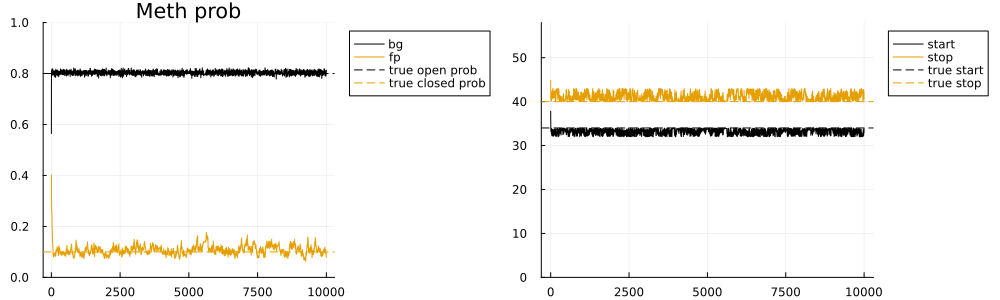

In [143]:
plot_model2A(fp_chain_2A_cp, smf_sample_stats_tf1)

## Observations on model2A

The footprint start and length (so end) is uniform between the informative positions that span the actual footprint start and stop

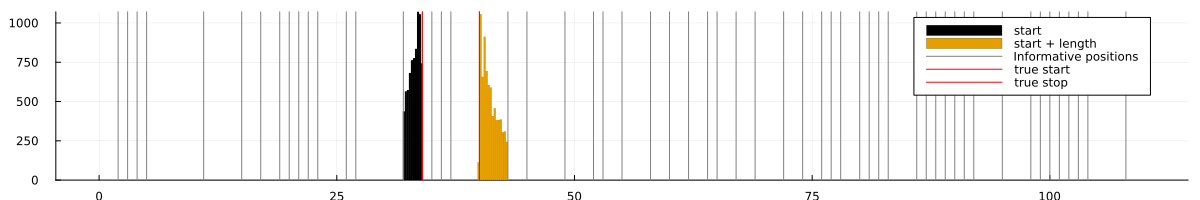

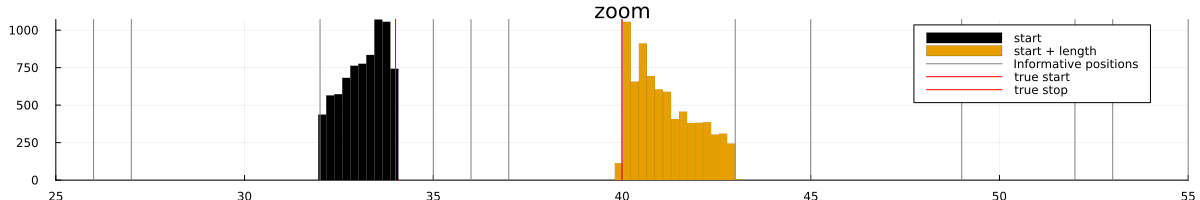

In [144]:
bins = range(extrema(smf_sample_stats_tf1.positions)..., length=500)
histogram(fp_chain_2A_cp["start"][2500:end], lab="start", bins=bins, line=stroke(0))
histogram!(fp_chain_2A_cp["start"][2500:end] .+ fp_chain_2A_cp["footprint_length"][2500:end] , lab="start + length", line=stroke(0), bins=bins)
vline!(smf_sample_stats_tf1.positions, c=:grey, size=(1200, 200), lab="Informative positions")
vline!(smf_sample_stats_tf1.positions[first.(smf_sample_stats_tf1.footprint_locations)], c=:red, lab="true start")
vline!(smf_sample_stats_tf1.positions[last.(smf_sample_stats_tf1.footprint_locations)], c=:red, lab="true stop")
plot!(fmt=:png, leg=:topright) |> display
plot!(fmt=:png, xlims=(25, 55), leg=:topright, title="zoom")

## Now multiple footprints

In [65]:

function fp_model2D_pos(sample)    
    totalfootprints = length(unique(sample.footprints)) -1
    fp_multiple_space_abs(totalfootprints, sample.positions, sample.totalmeth, sample.total)
end

@model function fp_multiple_space_abs(totalfootprints, positions, totalmeth, total, min_footprint=0, min_interval=0)
    footprint_starts    ~ filldist(Uniform(0, positions[end]-5), totalfootprints) ### where the footprints start
    footprint_lengths   ~ filldist(Gamma(2.5, 2), totalfootprints) ### ideally don't want to hard code the prior
    
    meth_bg ~ Beta(5, 2) ## methylation of background
    meth_fp ~ filldist(Beta(2, 5), totalfootprints) ### methylation rate at each footprint and the background
    
    
    ### Alternative implementation, loop over all footprints for each position
    infootprint = falses(length(positions)) ### use this to only allow a position to be assigned to one footprint
    # ifi = zeros(Int, length(positions))
    for i = 1:length(positions)
        mp = meth_bg
        for j = 1:totalfootprints
            if !infootprint[i] && (footprint_starts[j] < positions[i] < (footprint_starts[j] + footprint_lengths[j]))
                mp = meth_fp[j]
                infootprint[i] = true
                # ifi[i] = j
                
            end
        end
        totalmeth[i] ~ Binomial(total[i], mp)
    end
    
end

fp_multiple_space_abs (generic function with 6 methods)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  2.546149 seconds (11.12 M allocations: 1.061 GiB, 5.63% gc time, 57.91% compilation time: 91% of which was recompilation)


In [70]:
function plot_model_2D(chain, sample)
    totalfootprints = length(unique(sample.footprints)) -1

    p_meth = plot(ylims=(0, 1))
    plot!(chain["meth_bg"], lab="bg", title="Meth prob", c=0)
    for i = 1:totalfootprints
        plot!(chain["meth_fp[$i]"], lab="FP$i", c=i)
    end
    hline!([open_meth_prob], c=1, ls=:dash, lab="true open prob")
    hline!([closed_meth_prob], c=2, ls=:dash, lab="true closed prob")

    
    p_start = plot()
    for i = 1:totalfootprints
    
        plot!(chain["footprint_starts[$i]"], c=i, lab="$i")
        plot!(chain["footprint_starts[$i]"] .+ chain["footprint_lengths[$i]"], c=i, lab="")
        hline!(sample.positions[[sample.footprint_locations[i]...]], c=i, ls=:dash, lab="True FP$i")
        
    end
    plot(p_meth, p_start,layout=(1,2), size=(1000, 300), leg=:outertopright, fmt=:png)
    
end



    # yl = ylims()
    # plot!(ylims=(0, max(yl[2], length(smf_sample_stats_57.footprints))))
# plot!(fp_loc_chain_single["footprint_length"] .+ fp_loc_chain_single["start"], lab="stop")

# hline!(first.(smf_sample_stats_57.footprint_locations), ls=:dash, c=1, lab="true start")
# hline!(last.(smf_sample_stats_57.footprint_locations), ls=:dash, c=2, lab="true stop")


plot_model_2D (generic function with 1 method)

In [155]:
sampler = HMC(0.01, 5)
@time fp_chain_2D_cp = sample(fp_model2D_pos(smf_sample_stats_all), sampler, 10_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.378373 seconds (10.04 M allocations: 994.732 MiB, 21.29% gc time)


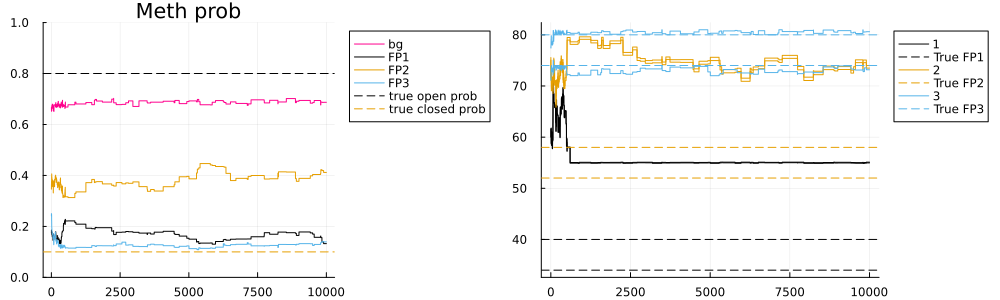

In [156]:
plot_model_2D(fp_chain_2D_cp, smf_sample_stats_all)

In [80]:
proposal_jump_dist(x; δ=5, p=0.05, σ=2.0) = MixtureModel(Normal.([x - 2*δ, x - δ, x, x + δ, x+2*δ], σ), [p/8, 3*p/8, 1-p, 3*p/8, p/8])

proposal_jump_dist (generic function with 4 methods)

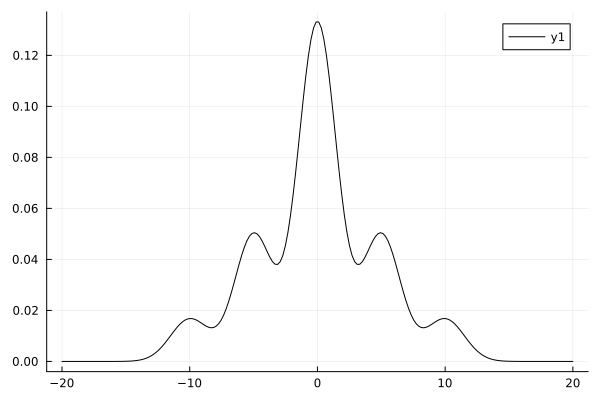

In [86]:
xp = range(-20, 20, length=200)
plot(xp, pdf.(proposal_jump_dist(0, p=0.5, σ=1.5), xp))

In [162]:
δ = 5
p = 0.05
σ = 1.5
sampler = Gibbs(MH(:footprint_starts => v -> [MixtureModel(Normal.([x - 2*δ, x - δ, x, x + δ, x+2*δ], σ), [p/8, 3*p/8, 1-p, 3*p/8, p/8]) for x in v]),
             HMC(0.01, 5,));
@time fp_chain_2D_cp = sample(fp_model2D_pos(smf_sample_stats_all), sampler, 10_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


  3.905700 seconds (22.08 M allocations: 2.060 GiB, 4.26% gc time, 37.92% compilation time)


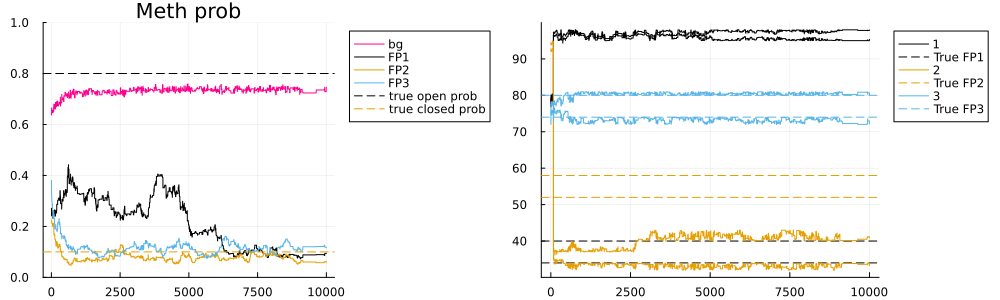

In [163]:
plot_model_2D(fp_chain_2D_cp, smf_sample_stats_all)

In [164]:
nr = 10
max_chain = nothing
mi = -Inf
@showprogress for i = 1:nr

    sample_chains = sample(fp_model2D_pos(smf_sample_stats_all), sampler, MCMCThreads(), 5_000, 8);
    fm, fi = findmax(sum(sample_chains["lp"], dims=1) |> vec)
    
    if fm > mi
        mi = fm
        max_chain = sample_chains[:, :, fi];
    end
end

Sampling (8 threads): 100%|█████████████████████████████| Time: 0:00:00
Sampling (8 threads): 100%|█████████████████████████████| Time: 0:00:00
Sampling (8 threads): 100%|█████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


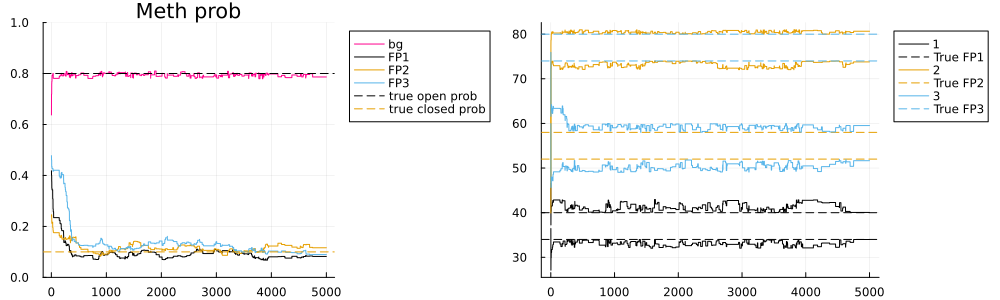

In [165]:
plot_model_2D(max_chain, smf_sample_stats_all)

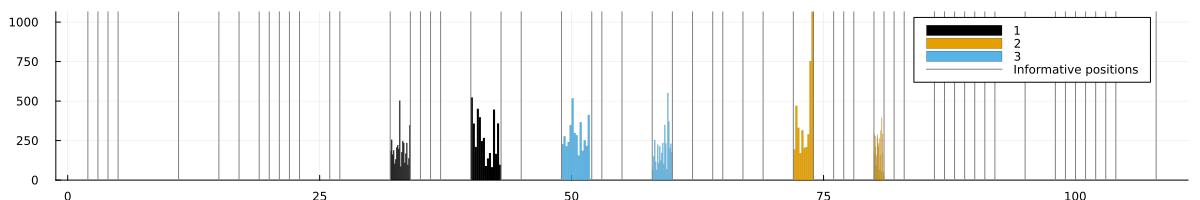

In [167]:
p = plot()
burnin = 1000
for i = 1:3
    histogram!(max_chain["footprint_starts[$i]"][burnin:end], line=stroke(0), c=i, lab="$i") 
    histogram!(max_chain["footprint_starts[$i]"][burnin:end] .+ max_chain["footprint_lengths[$i]"][burnin:end], line=stroke(0), c=i, lab="") 
end

vline!(smf_sample_stats_tf1.positions, c=:grey, size=(1200, 200), lab="Informative positions")
# vline!(smf_sample_stats_tf1.positions[first.(smf_sample_stats_tf1.footprint_locations)], c=:red, lab="true start")
# vline!(smf_sample_stats_tf1.positions[last.(smf_sample_stats_tf1.footprint_locations)], c=:red, lab="true stop")
plot!(leg=:topright)

In [101]:
using Suppressor, Optim

In [171]:
@time map_estimates = @showprogress [@suppress optimize(fp_model2D_pos(smf_sample_stats_all), MAP(), ParticleSwarm()) for k = 1:10];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.916866 seconds (4.68 M allocations: 317.291 MiB, 16.57% gc time, 9.50% compilation time)


In [172]:
map_estimate = argmax(c -> c.lp, map_estimates);

In [173]:
map_estimate.values

10-element Named Vector{Float64}
A                    │ 
─────────────────────┼──────────
footprint_starts[1]  │      34.0
footprint_starts[2]  │      74.0
footprint_starts[3]  │      52.0
footprint_lengths[1] │       6.0
footprint_lengths[2] │       6.0
footprint_lengths[3] │       6.0
meth_bg              │  0.794443
meth_fp[1]           │ 0.0783462
meth_fp[2]           │  0.111374
meth_fp[3]           │  0.108186

In [120]:
hk1desc

(chrom = "chr10", loc = 71108610:71108717, seq = "CATTTCCCGCAGGCAGAGTTTTTGCTTGCCCTGTATTCCAGCACAGGCTGGTACTCGAGACACATCTGTCCTGTGTTTGTTTTCCATTATTTGCTGGTAATAATGGCT", motifs = 3×8 DataFrame
 Row │ chrom    start     stop      name     seq        valid  rstart  rstop 
     │ String7  Int64     Int64     String7  String15   Bool   Int64   Int64 
─────┼───────────────────────────────────────────────────────────────────────
   1 │ chr10    71108643  71108649  NFAT     TATTCCA    false      34     40
   2 │ chr10    71108660  71108668  NKX2     GTACTCGAG  false      51     59
   3 │ chr10    71108683  71108689  FOX      TGTTTGT    false      74     80)